In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os, sys, re
import numpy as np
import random

from collections import defaultdict
from transformers import AutoTokenizer
from datasets import load_dataset
from grader import solution_eq_ans, extract_boxed_answer
from tqdm import tqdm

from rliable import plot_utils
plt.rcParams['text.usetex'] = False #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = r'\usepackage{sansmath} \sansmath' #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = ['Helveta Nue'] # Choose a nice font here
sns.set_style("whitegrid")

COLORS = ['#BBCC33', '#77AADD', '#44BB99',
           '#EEDD88', '#EE8866', '#FFAABB',
          '#99DDFF', '#44BB99', '#AAAA00',
          '#DDDDDD']
palette = sns.set_palette(COLORS)

/home/myang4/miniconda3/envs/vllm3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Merge data

In [ ]:
folders = ['base', 'mrt', 'grpo']
output_dir = "/home/myang4/mrt-analysis/outputs/regret"


In [ ]:
for folder in folders:
    data = {}
    for i in range(0, 15, 5):
        with open(os.path.join(output_dir, folder, f'pass_at_k_given_prefix/pass_at_k_given_prefix_{i}_{i+5}.pkl'), 'rb') as f:
            data |= pickle.load(f)
    
    with open(os.path.join(output_dir, folder, f'pass_at_k_given_prefix/pass_at_k_given_prefix.pkl'), "wb") as f:
        pickle.dump(data, f)

### Load stuff

In [4]:
math_dataset = load_dataset("hf-cmu-collab/math_reasoning_benchmark", split="AIME2025")
tokenizer = AutoTokenizer.from_pretrained("agentica-org/DeepScaleR-1.5B-Preview")

### Compute maj@k

In [5]:
def compute_maj_at_k(answers_dict, k, correct_answer):
    answers = []
    for key, probs in answers_dict.items():
        for p in probs:
            answers.append((key, p))
    
    reward = 0
    for _ in range(100000):
        perm = random.sample(answers, k=k)

        counts = {}

        # ========================
        # MAJORITY LOGPROBS
        # ========================

        for key, probs in perm:
            if key not in counts:
                counts[key] = 2 ** probs
            else:
                counts[key] += 2 ** probs

        if correct_answer not in counts:
            correct_ans_probs = float('-inf')
        else:
            correct_ans_probs = counts[correct_answer]

        max_other_ans_probs = float('-inf')
        for ans, probs in counts.items():
            if ans != correct_answer and ans is not None:
                max_other_ans_probs = max(max_other_ans_probs, probs)

        if correct_ans_probs > max_other_ans_probs:
            reward += 1
        elif correct_ans_probs < max_other_ans_probs:
            reward += 0
        else:
            if correct_ans_probs == float('-inf') and max_other_ans_probs == float('-inf'):
                reward += 0
            else:
                reward += 0.5
    
    return reward / 100000

def calculate_likelihoods(output, L):
    logprob = 0
    length = 0
    
    for prob_dict, id in zip(output.logprobs[-L:], output.token_ids[-L:]):
        if prob_dict is None:
            continue
        logprob += prob_dict[id].logprob
        length += 1
        
    return logprob / length

def compute_pass_at_k(n, c, k):
    if n - c < k:
        return 1.0
    
    return 1.0 - np.prod(1.0 - k / np.arange(n - c + 1, n + 1))

In [6]:
for folder in folders:
    output_dir = f"/home/myang4/mrt-analysis/outputs/regret/{folder}"

    with open(os.path.join(output_dir, "pass_at_k_given_prefix/pass_at_k_given_prefix.pkl"), "rb") as f:
        rollouts = pickle.load(f)

    problem_to_meta_step_to_pass_at_k_acc = defaultdict(list)
    n_to_answer_dict = defaultdict(list)

    for n, k_completions in tqdm(rollouts.items(), total=len(rollouts)):
        answer = str(math_dataset[n]['answer'])

        for c, completions in enumerate(k_completions):
            for prefix in completions:

                answers_dict = defaultdict(list)
                answers_dict[answer] = []

                total, correct = 0, 0
                
                for r, rollout in enumerate(prefix.outputs):

                    correct += solution_eq_ans(prefix.prompt + rollout.text, str(answer))
                    total += 1

                    likelihood = calculate_likelihoods(rollout, 100000)
                    
                    if extract_boxed_answer(prefix.prompt + rollout.text) is None:
                        answers_dict[None].append(likelihood)
                        continue
                    
                    cur_keys = list(answers_dict.keys())
                    found = False
                    for key in cur_keys:
                        if key is None:
                            continue
                        if solution_eq_ans(prefix.prompt + rollout.text, key):
                            answers_dict[key].append(likelihood)
                            found = True
                            break

                    if not found:
                        answers_dict[extract_boxed_answer(prefix.prompt + rollout.text)].append(likelihood)
                        assert solution_eq_ans(prefix.prompt + rollout.text, extract_boxed_answer(prefix.prompt + rollout.text))
            
                maj_at_k = [correct / total]
                for k in [2, 4, 8]:
                    maj_at_k.append(compute_maj_at_k(answers_dict, k, answer))

                problem_to_meta_step_to_pass_at_k_acc[n * len(k_completions) + c].append(np.array(maj_at_k))

            problem_to_meta_step_to_pass_at_k_acc[n * len(k_completions) + c] = np.array(problem_to_meta_step_to_pass_at_k_acc[n * len(k_completions) + c])

    with open(os.path.join(output_dir, "plot/maj@k.pkl"), "wb") as f:
        pickle.dump(problem_to_meta_step_to_pass_at_k_acc, f)

INFO 04-28 18:55:06 __init__.py:183] Automatically detected platform cuda.


2025-04-28 18:55:07,099	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
100%|██████████| 15/15 [17:35<00:00, 70.38s/it]


In [7]:
with open("/home/myang4/mrt-analysis/outputs/regret/base/plot/maj@k.pkl", "rb") as f:
    base_maj_at_k = pickle.load(f)
with open("/home/myang4/mrt-analysis/outputs/regret/mrt/plot/maj@k.pkl", "rb") as f:
    mrt_maj_at_k = pickle.load(f)
with open("/home/myang4/mrt-analysis/outputs/regret/grpo/plot/maj@k.pkl", "rb") as f:
    grpo_maj_at_k = pickle.load(f)

In [8]:
def get_all_areas(maj_at_k, budget):
    avg_ratio = []
    for t in range(len(maj_at_k)):
        total_area = 0
        red_area = 0
        
        for i in range(min(len(maj_at_k[t]) - 1, budget)):
            maj = list(maj_at_k[t][i])
            
            lst_x = [1, 2, 4, 6]
            green_y = [maj[0], maj[1], maj[2], (maj[2] + maj[3]) / 2]
            blue_y = [maj[0] + (x - 1) / (6 - 1) * (maj_at_k[t][i+1][0] - maj[0]) for x in lst_x]
            optimal_y = [max(green_y[i], blue_y[i]) for i in range(len(green_y))]

            red_area += np.trapz(optimal_y, lst_x) - np.trapz(blue_y, lst_x)
            total_area += np.trapz(optimal_y, lst_x)
        
        if total_area == 0:
            continue
        avg_ratio.append(red_area / total_area)

    return sum(avg_ratio) / len(avg_ratio)

In [9]:
mrt_areas = [get_all_areas(mrt_maj_at_k, b) for b in range(1, 7)]
grpo_areas = [get_all_areas(grpo_maj_at_k, b) for b in range(1, 7)]
base_areas = [get_all_areas(base_maj_at_k, b) for b in range(1, 7)]

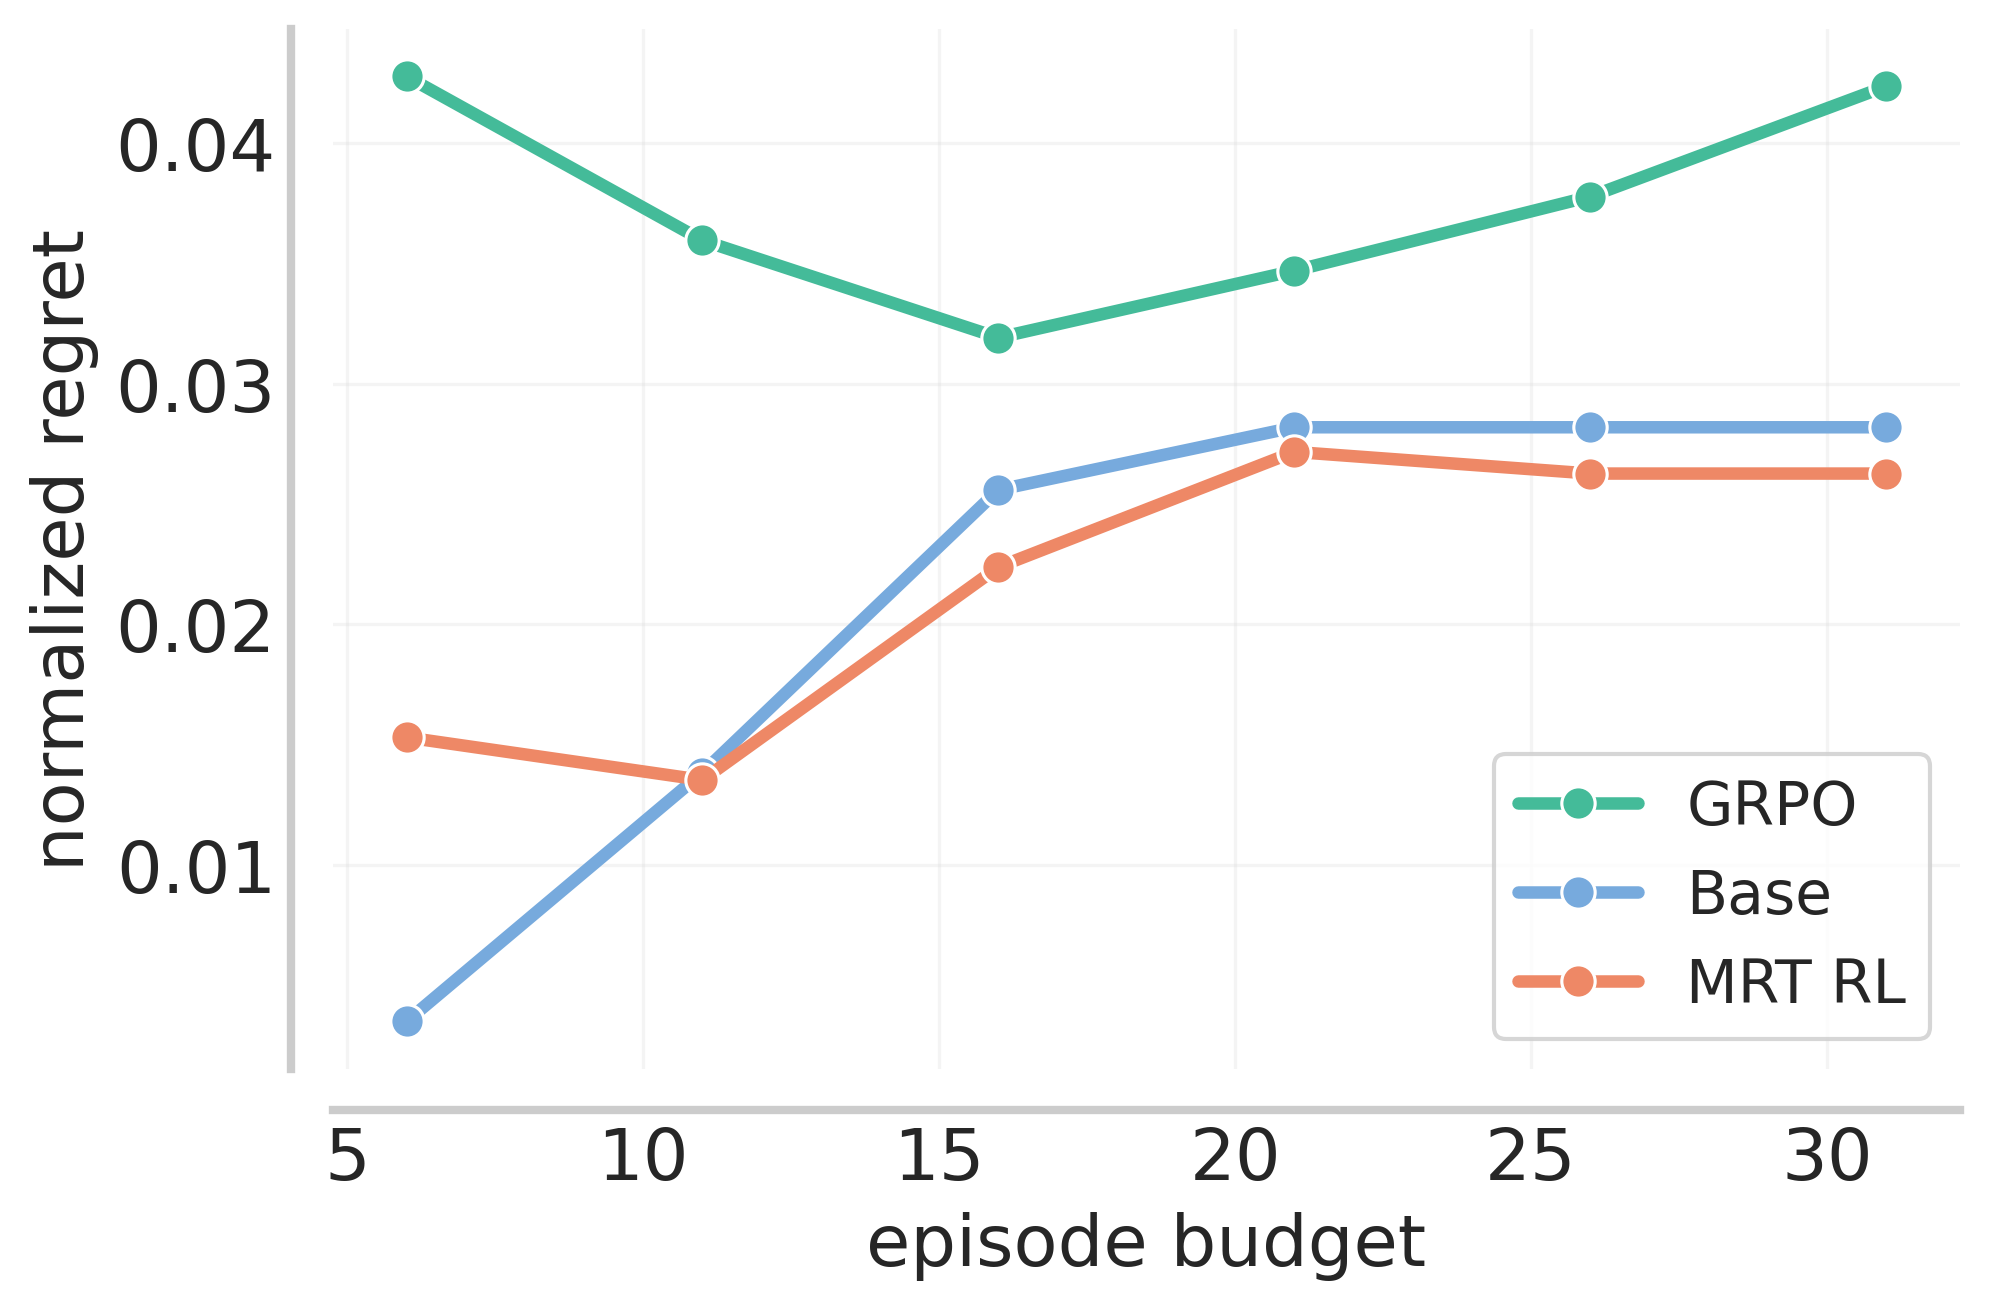

In [ ]:
fig, ax = plt.subplots(figsize=(14 / 2, 4.5), dpi=300)

x = [1 + b * 5 for b in range(1, 7)]
sns.lineplot(x=x, y=grpo_areas, label="GRPO", ax=ax, marker='o', linewidth=3, markersize=8, color=COLORS[2])
sns.lineplot(x=x, y=base_areas, label="Base", ax=ax, marker='o', linewidth=3, markersize=8, color=COLORS[1])
sns.lineplot(x=x, y=mrt_areas, label="MRT RL", ax=ax, marker='o', linewidth=3, markersize=8, color=COLORS[4])

plot_utils._annotate_and_decorate_axis(ax,
                                        xlabel='episode budget',
                                        ylabel=f"normalized regret",
                                        labelsize='xx-large',
                                        ticklabelsize='xx-large',
                                        grid_alpha=0.2,
                                        legend=True)

plt.show()